In [1]:
## Set Up Notebook ##

# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis
# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls


## Set Up Notebook

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 864, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 864 (delta 139), reused 120 (delta 47), pack-reused 620 (from 1)
Receiving objects: 100% (864/864), 27.23 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (493/493), done.
Filtering content: 100% (32/32), 1.75 GiB | 32.01 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
## Set Up Notebook ##

!pip install numpy==1.26.3 # necessary for bug fix
!pip install ta
!pip install pykalman
!pip install PyWavelets

## Set Up Notebook

In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_na  ns, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac

# important for time moe
# import wandb
# wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
# from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

In [4]:
## Gather Data ##

startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01' # possibly change to 07-01 (option 1; dev data in end_year - 1 (e.g. 2023), test data in end_year (e.g. 2024) // option 2; dev data 1st half end_year, test data 2nd half end_year)
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.



## Gather Data ##

In [15]:
# Goal: find out why so many returns show gt_yoy -15.275%

verbose = False

def return_score(yoy_mean, gt_yoy):
  return round((1 + yoy_mean) / (1 + gt_yoy), 2)

# output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
# gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']

## definition of trade func ##


def trade(
        S1: pd.Series,
        S2: pd.Series,
        spread: pd.Series, # model-predicted spread for the strategy
        window_long: int,
        window_short: int,
        position_threshold: float = 1.0,
        clearing_threshold: float = 0.5,
        risk_fraction: float = 0.1 # could be used again
    ):
    if len(spread) != len(S1) or len(spread) != len(S2):
        raise ValueError("Length of S1, S2, and spread must be the same")
    # Compute rolling mean and rolling standard deviation

    ma_long = spread.rolling(window=window_long, center=False).mean()
    ma_short = spread.rolling(window=window_short, center=False).mean()
    std = spread.rolling(window=window_short, center=False).std()
    zscore = (ma_long - ma_short)/std

    # Calculate initial cash based on average range of S1, S2 and Spread_Close, as these also determine the size of the trades
    s2_spread = max(S2) - min(S2)
    s1_spread = max(S1) - min(S1)
    spread_spread = max(spread) - min(spread)
    avg_spread = (s2_spread + s1_spread + spread_spread) / 3
    initial_cash = avg_spread * len(spread) # the absolute returns are correlated to the length of the spread, times the average range.
    # overwrite initial_cash to standard value
    initial_cash = 10000

    # Simulate trading
    # Start with no money and no positions
    cash = initial_cash # initial cash amount, perhaps not hardcoded in the future
    qty_s1 = 0
    qty_s2 = 0
    returns = [initial_cash]

    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore.iloc[i] > position_threshold:
            # print(f"[NEW] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash += S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            qty_s1 -= 1
            qty_s2 += spread.iloc[i]
        # Buy long if the z-score is < 1
        elif zscore.iloc[i] < -position_threshold:
            # print(f"[NEW] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash -= S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            qty_s1 += 1
            qty_s2 -= spread.iloc[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore.iloc[i]) < clearing_threshold:
            # print(f"[NEW] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash += qty_s1 * S1.iloc[i] - S2.iloc[i] * qty_s2
            qty_s1 = 0
            qty_s2 = 0
        returns.append(cash) # append the current cash value to returns
    # If at any point returns is 0, all values after that is zero
    zero_from_this_idx = -1
    for i in range(len(returns)):
        if returns[i] <= 0:
            zero_from_this_idx = i
            break
    if zero_from_this_idx > -1:
        returns[zero_from_this_idx:] = [0] * (len(returns) - zero_from_this_idx)

    # Shrink returns by a factor such that returns are not inflated.
    returns_series = pd.Series(returns)
    alpha = 0.1  # Shrinking/stretching factor
    returns_uninflated = returns_series.copy()
    mask = returns_series > initial_cash
    returns_uninflated[mask] = initial_cash + alpha * (returns_series[mask] - initial_cash)
    returns_uninflated = returns_uninflated.tolist()

    return returns_uninflated


## definition of trade func


timeseries_unprofitable = []
timeseries_profitable = []

## Preparing for trade
for i in range(len(pairs_data_filtered)):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pair_tup_str_current = f"({ticker_a},{ticker_b})"
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

  burn_in = 30
  look_back = 20

  pairs_timeseries_df_burned_in = pairs_timeseries_df.iloc[burn_in:].copy()

  total_len = len(pairs_timeseries_df_burned_in)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = pairs_timeseries_df_burned_in.iloc[:train_size]
  dev   = pairs_timeseries_df_burned_in.iloc[train_size:train_size + dev_size]
  test  = pairs_timeseries_df_burned_in.iloc[train_size + dev_size:]


  index_shortened = test.index[:len(test['Spread_Close'].values[look_back:])] # problem: test['S1_close'].iloc[look_back:] and testY_untr are the same.. So we should rather be using test
  spread_gt_series = pd.Series(test['Spread_Close'].values[look_back:], index=index_shortened)
  gt_returns_test = trade(
      S1 = test['S1_close'].iloc[look_back:],
      S2 = test['S2_close'].iloc[look_back:],
      spread = spread_gt_series,
      window_long = 30,
      window_short = 5,
      position_threshold = 3,
      clearing_threshold = 0.4
  )

  ## Preparing for trade

  # plt.plot(gt_returns_test)
  gt_yoy_test = ((gt_returns_test[-1] / gt_returns_test[0])**(232 / len(gt_returns_test)) - 1) # should be -100, but is -15..
  print(gt_yoy_test)
  if gt_yoy_test < -0.99:
    timeseries_unprofitable.append((train, dev, test))
  else:
    timeseries_profitable.append((train, dev, test))

0.020931007337921637
-1.0
0.0723128658560368
0.008752546953437301
-1.0
-0.47037563254892034
-1.0
4.785235020964784
1.9733132748176931
-1.0
0.0398909225689148
-1.0
1.2670809730464314
8.868132561102678
0.018237098104780358
-1.0
1.7432821082693417
-1.0
-1.0
-0.4279133854072428
3.695024554655274
-1.0
-1.0
0.007887762782601282
-1.0
3.3244533226445308
-1.0
-1.0
0.8412458556031881
0.1305934402254212
-1.0
2.1116305362202277
0.2550074907544648
-1.0
-1.0
-0.011092336443212836
0.2369322958942428
0.8167691354564885
-1.0
0.036205107373399104
6.320417696370613
-1.0
2.619843616025543
-1.0
0.015553846312416741
0.11329536604554535
-1.0
0.024733272806903628
14.952935571050498
1.3322686683982803
0.09585534661848083
-1.0
2.289618108407116
5.0532437147867535
0.027206706740262154
1.1688299869177912
-1.0
0.6072773555829407
-1.0
-1.0
0.7522905370306183
0.45700529332185624
3.5647459245111186
-1.0
2.4623712196740017
-1.0
0.48739815875685855
1.6888194878165326
0.44443086646939367
0.6242071972454257
1.09250986073

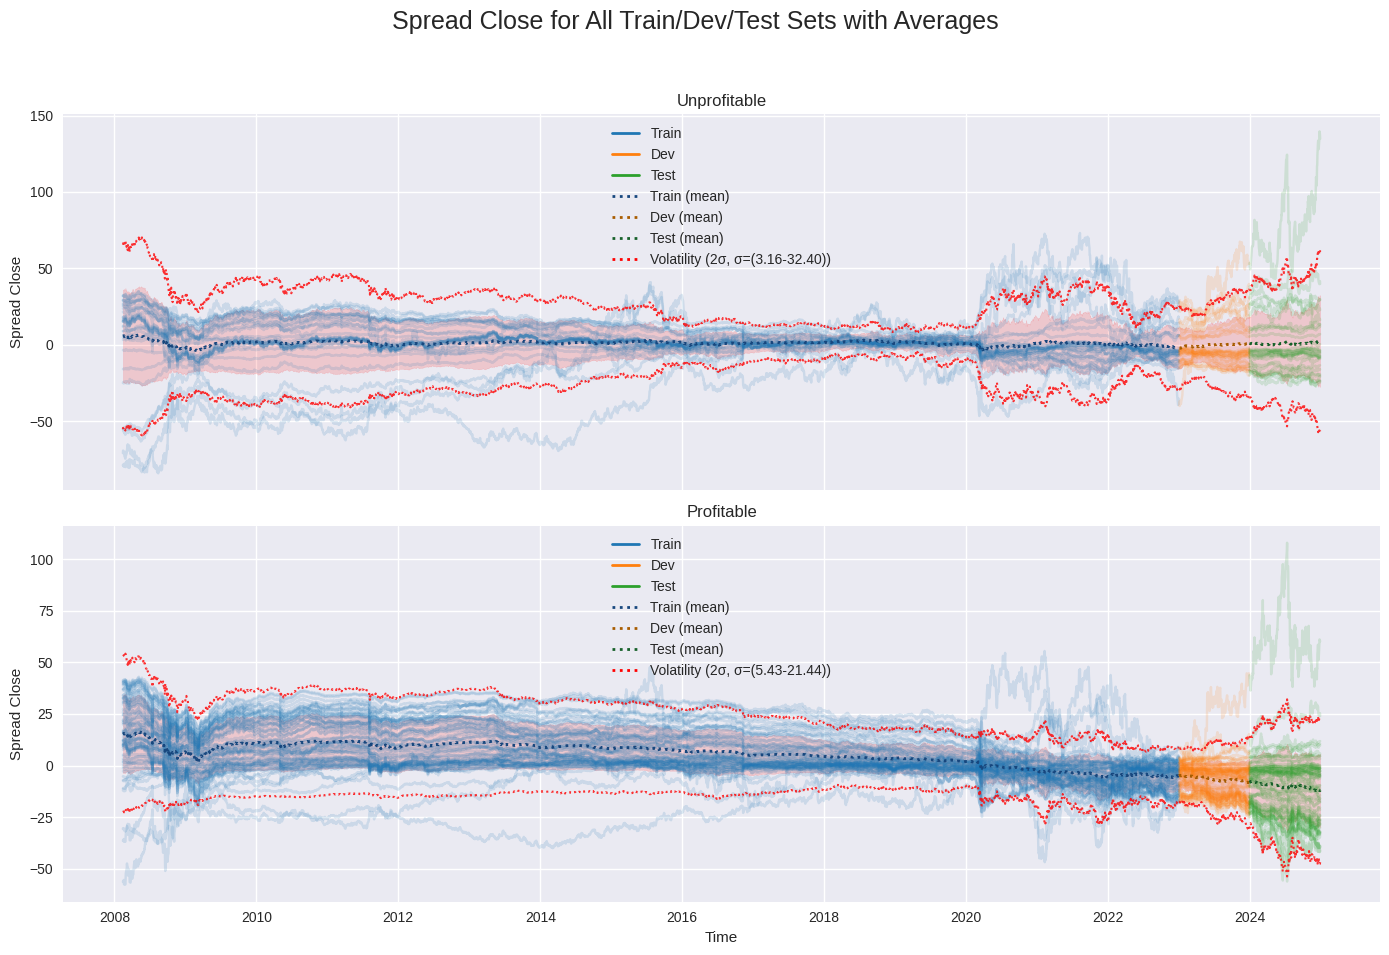

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Define colors for train, dev, test
train_color = 'tab:blue'
dev_color = 'tab:orange'
test_color = 'tab:green'
train_color_dark = '#17477e'
dev_color_dark = '#a85c00'
test_color_dark = '#17612a'
volatility_color = 'red'

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
fig.suptitle("Spread Close for All Train/Dev/Test Sets with Averages", fontsize=18)

# ------- Unprofitable subplot -------
train_series = []
dev_series = []
test_series = []

ax = axs[0]
for train, dev, test in timeseries_unprofitable:
    ax.plot(train['Spread_Close'], color=train_color, alpha=0.15)
    ax.plot(dev['Spread_Close'], color=dev_color, alpha=0.15)
    ax.plot(test['Spread_Close'], color=test_color, alpha=0.15)
    train_series.append(train['Spread_Close'])
    dev_series.append(dev['Spread_Close'])
    test_series.append(test['Spread_Close'])

train_df = pd.concat(train_series, axis=1)
dev_df = pd.concat(dev_series, axis=1)
test_df = pd.concat(test_series, axis=1)

train_mean = train_df.mean(axis=1)
train_std = train_df.std(axis=1)
dev_mean = dev_df.mean(axis=1)
dev_std = dev_df.std(axis=1)
test_mean = test_df.mean(axis=1)
test_std = test_df.std(axis=1)

ax.plot(train_mean.index, train_mean, color=train_color_dark, linestyle=':', linewidth=2, alpha=1, label='Train (mean)')
ax.plot(dev_mean.index, dev_mean, color=dev_color_dark, linestyle=':', linewidth=2, alpha=1, label='Dev (mean)')
ax.plot(test_mean.index, test_mean, color=test_color_dark, linestyle=':', linewidth=2, alpha=1, label='Test (mean)')

for mean, std in [(train_mean, train_std), (dev_mean, dev_std), (test_mean, test_std)]:
    ax.fill_between(mean.index, mean-std, mean+std, color=volatility_color, alpha=0.15)
    ax.plot(mean.index, mean+2*std, color=volatility_color, linestyle=':', linewidth=1.5, alpha=0.8)
    ax.plot(mean.index, mean-2*std, color=volatility_color, linestyle=':', linewidth=1.5, alpha=0.8)

custom_lines = [
    Line2D([0], [0], color=train_color, lw=2, alpha=1, label='Train'),
    Line2D([0], [0], color=dev_color, lw=2, alpha=1, label='Dev'),
    Line2D([0], [0], color=test_color, lw=2, alpha=1, label='Test'),
    Line2D([0], [0], color=train_color_dark, lw=2, linestyle=':', alpha=1, label='Train (mean)'),
    Line2D([0], [0], color=dev_color_dark, lw=2, linestyle=':', alpha=1, label='Dev (mean)'),
    Line2D([0], [0], color=test_color_dark, lw=2, linestyle=':', alpha=1, label='Test (mean)'),
    Line2D([0], [0], color=volatility_color, lw=2, linestyle=':', alpha=1,
           label=f'Volatility (2σ, σ=({min([train_std.min(), dev_std.min(), test_std.min()]):.2f}-{max([train_std.max(), dev_std.max(), test_std.max()]):.2f}))'),
]
ax.legend(handles=custom_lines)
ax.set_title("Unprofitable")
ax.set_ylabel("Spread Close")

# ------- Profitable subplot -------
train_series = []
dev_series = []
test_series = []

ax = axs[1]
for train, dev, test in timeseries_profitable:
    ax.plot(train['Spread_Close'], color=train_color, alpha=0.15)
    ax.plot(dev['Spread_Close'], color=dev_color, alpha=0.15)
    ax.plot(test['Spread_Close'], color=test_color, alpha=0.15)
    train_series.append(train['Spread_Close'])
    dev_series.append(dev['Spread_Close'])
    test_series.append(test['Spread_Close'])

train_df = pd.concat(train_series, axis=1)
dev_df = pd.concat(dev_series, axis=1)
test_df = pd.concat(test_series, axis=1)

train_mean = train_df.mean(axis=1)
train_std = train_df.std(axis=1)
dev_mean = dev_df.mean(axis=1)
dev_std = dev_df.std(axis=1)
test_mean = test_df.mean(axis=1)
test_std = test_df.std(axis=1)

ax.plot(train_mean.index, train_mean, color=train_color_dark, linestyle=':', linewidth=2, alpha=1, label='Train (mean)')
ax.plot(dev_mean.index, dev_mean, color=dev_color_dark, linestyle=':', linewidth=2, alpha=1, label='Dev (mean)')
ax.plot(test_mean.index, test_mean, color=test_color_dark, linestyle=':', linewidth=2, alpha=1, label='Test (mean)')

for mean, std in [(train_mean, train_std), (dev_mean, dev_std), (test_mean, test_std)]:
    ax.fill_between(mean.index, mean-std, mean+std, color=volatility_color, alpha=0.15)
    ax.plot(mean.index, mean+2*std, color=volatility_color, linestyle=':', linewidth=1.5, alpha=0.8)
    ax.plot(mean.index, mean-2*std, color=volatility_color, linestyle=':', linewidth=1.5, alpha=0.8)

custom_lines = [
    Line2D([0], [0], color=train_color, lw=2, alpha=1, label='Train'),
    Line2D([0], [0], color=dev_color, lw=2, alpha=1, label='Dev'),
    Line2D([0], [0], color=test_color, lw=2, alpha=1, label='Test'),
    Line2D([0], [0], color=train_color_dark, lw=2, linestyle=':', alpha=1, label='Train (mean)'),
    Line2D([0], [0], color=dev_color_dark, lw=2, linestyle=':', alpha=1, label='Dev (mean)'),
    Line2D([0], [0], color=test_color_dark, lw=2, linestyle=':', alpha=1, label='Test (mean)'),
    Line2D([0], [0], color=volatility_color, lw=2, linestyle=':', alpha=1,
           label=f'Volatility (2σ, σ=({min([train_std.min(), dev_std.min(), test_std.min()]):.2f}-{max([train_std.max(), dev_std.max(), test_std.max()]):.2f}))'),
]
ax.legend(handles=custom_lines)
ax.set_title("Profitable")
ax.set_xlabel("Time")
ax.set_ylabel("Spread Close")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle
plt.show()